In [477]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Загрузка данных

In [478]:
%%capture
!wget https://www.dropbox.com/s/64ol9q9ssggz6f1/data_ford_price.xlsx

In [479]:
data = pd.read_excel('data/data_ford_price.xlsx') 

In [480]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


# Предобработка: удаление пропусков

In [481]:
data[~data['weather'].isna()]

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
5,6995,2003,3,8,167662,clean,automatic,4wd,full-size,45.518031,-122.578752,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7012,22500,2015,3,6,23500,clean,automatic,rwd,full-size,32.680700,-117.169800,59.0
7013,5975,2005,2,8,0,clean,automatic,rwd,full-size,38.213303,-85.785762,50.0
7014,9999,2006,3,8,161514,clean,automatic,NaN,full-size,37.609783,-120.995406,59.0
7015,10900,2011,2,8,164000,clean,automatic,4wd,full-size,43.140600,-93.385000,47.0


In [482]:
y = data['price']
x = data.drop(columns='price')

In [483]:
x = x.dropna()

In [484]:
y = y.iloc[x.index]

In [485]:
x.shape[0]==y.shape[0]

True

In [486]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [487]:
from sklearn.preprocessing import OneHotEncoder

In [488]:
# Проведём кодирование OneHot-методом категориальных переменных.
one_hot_encoder = OneHotEncoder()

In [489]:
columns_to_change = ['cylinders', 'title_status', 'transmission', 'drive', 'size']

In [490]:
# Обучаем энкодер и сразу применяем преобразование к выборке. Результат переводим в массив:
X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()

In [491]:
# Затем применяем полученное преобразование к тестовой выборке. Результат переводим в массив:
X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()

In [492]:
# Для удобства сохраним полученные названия новых колонок в отдельную переменную:
columns = one_hot_encoder.get_feature_names_out(columns_to_change)
columns[:10]

array(['cylinders_3', 'cylinders_4', 'cylinders_5', 'cylinders_6',
       'cylinders_8', 'cylinders_10', 'title_status_clean',
       'title_status_lien', 'title_status_missing',
       'title_status_rebuilt'], dtype=object)

In [493]:
# Теперь у нас есть массив закодированных признаков и наша изначальная таблица. Чтобы соединить эти данные, переведём массив в формат DataFrame.
X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)

Переустановим индексацию в таблицах, применив подряд сразу два метода: reset_index() — для изменения индексов с рандомных на последовательные от 0 до n и drop(['index'], axis = 1) — для удаления образовавшегося столбца 'index'.

In [494]:
X_train = X_train.reset_index().drop(['index'], axis = 1)
X_test = X_test.reset_index().drop(['index'], axis = 1)
 
y_train = y_train.reset_index().drop(['index'], axis = 1)
y_test = y_test.reset_index().drop(['index'], axis = 1)

In [495]:
# Объединяем таблицы и удаляем старые категориальные признаки:
X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
 
X_train_new = X_train_new.drop(columns=columns_to_change)
X_test_new = X_test_new.drop(columns=columns_to_change)

In [496]:
# Настало время обучить модель. Для этого создаём объект класса LinearRegression.
lr_model = LinearRegression()

In [497]:
lr_model.fit(X_train_new, y_train)

LinearRegression()

In [498]:
y_train_predict = lr_model.predict(X_train_new)

In [499]:
y_test_predict = lr_model.predict(X_test_new)
print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_predict)))

Train R^2: 0.647
Test R^2: 0.693


## Кодирование категориальных переменных

In [500]:
def encode_cat_features(columns_to_change, X_train, X_test, y_train):
    one_hot_encoder = OneHotEncoder()
    X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()
    X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()

    columns = one_hot_encoder.get_feature_names_out(columns_to_change)
    
    X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
    X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)

    X_train = X_train.reset_index().drop(['index'], axis = 1)
    X_test = X_test.reset_index().drop(['index'], axis = 1)
    y_train = y_train.reset_index().drop(['index'], axis = 1)

    X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
    X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
    
    X_train_new = X_train_new.drop(columns=columns_to_change)
    X_test_new = X_test_new.drop(columns=columns_to_change)

    return X_train_new, X_test_new

In [501]:
X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test, y_train)

## Обучение модели 

In [502]:
lr_model = LinearRegression()

In [503]:
lr_model.fit(X_train_new, y_train)
y_train_predict = lr_model.predict(X_train_new)
y_test_predict = lr_model.predict(X_test_new)
print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_predict)))

Train R^2: 0.647
Test R^2: 0.693


# Предобработка: заполнение пропусков

In [504]:
y = data['price']
x = data.drop(columns='price')

In [505]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [506]:
X_train['weather'] = X_train['weather'].fillna(np.round(np.mean(X_train['weather']),0))
X_test['weather'] = X_test['weather'].fillna(np.round(np.mean(X_train['weather']),0))

In [507]:
X_train['drive'].value_counts(True).head(1)

drive
4wd    0.738406
Name: proportion, dtype: float64

In [508]:
X_train['size'].value_counts(True).head(1)


size
full-size    0.841164
Name: proportion, dtype: float64

In [509]:
X_train['size'] = X_train['size'].fillna('full-size')
X_train['drive'] = X_train['drive'].fillna('4wd')
 
X_test['size'] = X_test['size'].fillna('full-size')
X_test['drive'] = X_test['drive'].fillna('4wd')

In [510]:
X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test, y_train)

In [511]:
lr_model = LinearRegression()
lr_model.fit(X_train_new, y_train)
y_train_predict = lr_model.predict(X_train_new)
y_test_predict = lr_model.predict(X_test_new)
print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_predict)))

Train R^2: 0.649
Test R^2: 0.465


# Предсказание пропусков с помощью ML

In [512]:
data = x.copy()
 
test_data = data[data['weather'].isnull()]
data.dropna(inplace=True)
 
y_train = data['weather']
X_train = data.drop(['size','weather','drive'], axis=1)
X_test = test_data.drop(['size','weather','drive'], axis=1)


In [513]:
categorial_cols = ['cylinders', 'title_status', 'transmission']

In [514]:
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

In [515]:
model = LinearRegression()
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)
y_pred

array([ 40.91435555,  40.7637233 ,  39.74866152,  41.2755305 ,
        40.31791932,  41.10796547,  41.15337846,  39.94866488,
        41.10796547,  40.7217165 ,  40.18904454,  91.62094167,
        41.12549856,  41.33052316,  39.66827354,  40.91435555,
        40.77287826,  40.84208674,  41.10796547,  41.02118034,
        40.31791932,  41.30309209,  40.77645269,  40.75842615,
        40.61605044,  40.79031628,  40.7701239 ,  39.78723017,
        41.27231621,  39.77492057,  40.7637233 ,  40.7701239 ,
        41.10796547,  39.68313064,  40.12277414,  39.7873657 ,
        41.07798631,  41.06812063,  40.7637233 ,  40.90194049,
        41.10796547,  70.85737739,  30.44339508,  40.76125291,
        39.77492057,  41.12549856,  39.74864816,  40.72219488,
        40.97162064,  40.7448585 ,  39.71065847,  39.78779447,
        39.77492057,  40.15945849,  41.12549856,  40.7902779 ,
        39.65555168,  41.10796547,  40.76125291,  40.15619215,
        40.79031628,  41.10796547,  40.7902779 ,  40.72

In [516]:
# Импортируем необходимые модули
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

# Скопируем данные в отдельную переменную
data = x.copy()
 
# В качестве тестовой выборки возьмем строки с пропусками в признаке weather
test_data = data[data['weather'].isnull()]
# И удалим эти строчки из таблицы
data.dropna(inplace=True)

# Определим целевой признак и факторы
y_train = data['weather']
X_train = data.drop(['size','weather','drive'], axis=1)
X_test = test_data.drop(['size','weather','drive'], axis=1)

# Создадим кодировщик
one_hot_encoder = OneHotEncoder()
categorial_cols = ['cylinders', 'title_status', 'transmission']

# Закодируем категориальные признаки (обучаем кодировщик только на тренировочной выборке)
X_train_onehot = one_hot_encoder.fit_transform(X_train[categorial_cols]).toarray()
X_test_onehot = one_hot_encoder.transform(X_test[categorial_cols]).toarray()

# Результаты преобразуем обратно в DataFrame для удобства
columns = one_hot_encoder.get_feature_names_out(categorial_cols)
X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)

# Сбросим индексы таблиц
X_train = X_train.reset_index().drop(['index'], axis = 1)
X_test = X_test.reset_index().drop(['index'], axis = 1)
y_train = y_train.reset_index().drop(['index'], axis = 1)

# Добавим результаты кодирования к исходным таблицам
X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)

# Удалим столбцы, которые уже были закодированы
X_train_new = X_train_new.drop(columns=categorial_cols)
X_test_new = X_test_new.drop(columns=categorial_cols)

# Создадим модель линейной регрессии и обучим ее на задачу предсказания пропусков
model = LinearRegression()
model.fit(X_train_new, y_train)

# Сделаем предсказание целевой переменной (пропущенных значений в признаке weather) 
y_pred = model.predict(X_test_new)

In [517]:
data['size'].unique()

array(['full-size', 'mid-size', 'compact', 'sub-compact'], dtype=object)

In [518]:
data = x.copy()
test_data = data[data['size'].isnull()]
data.dropna(inplace=True)

y_train = data['size']
X_train = data.drop(['size','weather','drive'], axis=1)
X_test = test_data.drop(['size','weather','drive'], axis=1)

In [519]:
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

In [520]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth= 5, random_state=42)
model.fit(X_train_new, y_train)


RandomForestClassifier(max_depth=5, random_state=42)

In [521]:
y_pred = model.predict(X_test_new)

In [522]:
for i, ni in enumerate(test_data.index):
    x.loc[ni, 'size'] = y_pred[i]

## Решение Задания 4.5


Вставьте найденную замену на место пропусков в столбце weather. Используйте тот же метод для заполнения пропусков в size. Обратите внимание на тип модели, который нужен (классификация или регрессия) в зависимости от типа признака. 

In [523]:
for i, ni in enumerate(test_data.index):
    x.loc[ni, 'weather'] = y_pred[i]

C:\Users\kinde\AppData\Local\Temp\ipykernel_13244\2043549582.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'full-size' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  x.loc[ni, 'weather'] = y_pred[i]


In [524]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1564 entries, 4 to 7011
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          1564 non-null   int64  
 1   condition     1564 non-null   int64  
 2   cylinders     1564 non-null   int64  
 3   odometer      1564 non-null   int64  
 4   title_status  1564 non-null   object 
 5   transmission  1564 non-null   object 
 6   drive         1330 non-null   object 
 7   size          0 non-null      object 
 8   lat           1564 non-null   float64
 9   long          1564 non-null   float64
 10  weather       1479 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 146.6+ KB


In [525]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          7017 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       6922 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 603.2+ KB


<Axes: >

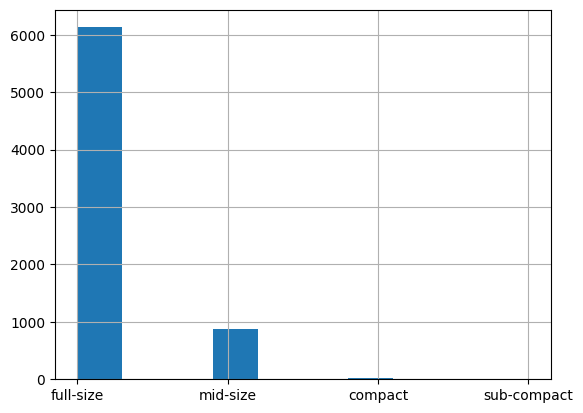

In [526]:
x['size'].hist()

Данный признак является категориальным. Следовательно, понадобится классификатор для заполения пропусков в нем.

In [546]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          7017 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       6922 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 603.2+ KB


# Пребодработка: работа с выбросами

In [550]:
data = pd.read_excel('data/data_ford_price.xlsx') 

In [551]:
data = data[['price', 'year', 'cylinders', 'odometer' ,'lat', 'long','weather']]
data.dropna(inplace = True)

In [552]:
y = data['price']
x = data.drop(columns='price')
x.head()

,year,cylinders,odometer,lat,long,weather
0,2016,6,43500,36.471500,-82.483400,59.0
1,2009,8,98131,40.468826,-74.281734,52.0
2,2002,8,201803,42.477134,-82.949564,45.0
3,2000,8,170305,40.764373,-82.349503,49.0
5,2003,8,167662,45.518031,-122.578752,50.0


In [553]:
from sklearn.metrics import mean_absolute_error

In [555]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)


MAE: 4682.957


In [556]:
from  sklearn.ensemble import IsolationForest
 
# ищем выбросы в обучающей выборке
iso = IsolationForest(contamination=0.1)
iso.fit(X_train.values)
y_predicted = iso.predict(X_train.values)

In [557]:
# выберем все строки, которые не являются выбросами
mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(4306, 6) (4306,)
MAE: 4454.891


In [558]:
from sklearn.neighbors import LocalOutlierFactor
 
lof = LocalOutlierFactor()
y_predicted = lof.fit_predict(X_train)

mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(3986, 6) (3986,)
MAE: 4454.878


In [559]:
from sklearn.covariance import EllipticEnvelope
 
ee = EllipticEnvelope(contamination=0.01)
y_predicted = ee.fit_predict(X_train)

mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(3946, 6) (3946,)
MAE: 4455.073
